<a href="https://colab.research.google.com/github/astrfo/SRS-CH/blob/main/SRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRS-CH 実装

[満足化方策における非満足均衡を用いた確率的方策の検証] \\
https://www.jstage.jst.go.jp/article/pjsai/JSAI2021/0/JSAI2021_1G2GS2a04/_article/-char/ja/


[論文要約] \\
https://colab.research.google.com/drive/1PGbrYECAT7JiiOF_Zu0Sg8CzqjPTJE87#scrollTo=iaPmWlGNgFbd




In [267]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [268]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.random.rand(K)

    def swap_prob(self):            # 2,000step毎に確率を入れ替える
        self.prob = self.prob

    def play(self, arm):
        if self.prob[arm] > np.random.rand():
            return 1
        else:
            return 0

In [269]:
class TS(object):
    """
    Thompson Sampling
    """

    def __init__(self, K):
        self._K = K
        self._S = None      # Success
        self._F = None      # Failure

    def initialize(self):
        self._S = np.ones(self._K)
        self._F = np.ones(self._K)

    def select_arm(self):
        theta = np.array([np.random.beta(self._S[i], self._F[i]) for i in range(self._K)])
        arm = np.random.choice(np.where(theta == theta.max())[0])
        return arm

    def update(self, arm, reward):
        if reward == 1:
            self._S[arm] += 1
        else:
            self._F[arm] += 1

In [270]:
class RS_CH(object):
    """
    RS-CH
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self._aleph = None
        self._RS = None

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0
        self._aleph = np.zeros(self._K)
        self._RS = (self._n / (self._N+1)) * (self._V - self._aleph)

    def select_arm(self):
        G = random.choice(np.where(self._V == self._V.max())[0])
        RSG = (self._n[G] / (self._N+1)) * (self._V[G] - self._aleph)
        mu = np.exp(-self._n * self.D_KL(self._V, self._V[G]))
        mu[G] = 0.0
        self._aleph = self._V[G] * (1 - (self._V/self._V[G]) * mu) / (1 - mu)
        np.nan_to_num(self._aleph, copy=False, nan=0)
        exceed_RSG_index = np.where(RSG <= self._RS)[0]

        if len(exceed_RSG_index) == 1:
            arm = G
        else:
            if len(np.where(RSG < self._RS)[0]) == 1:
                arm = np.where(RSG < self._RS)[0][0]
            else:
                exceed_mu = mu[exceed_RSG_index]
                max_mu_index = np.where(exceed_mu.max() == exceed_mu)[0]
                if len(max_mu_index) == 1:
                    arm = exceed_RSG_index[max_mu_index[0]]
                else:
                    exceed_aleph = self._aleph[max_mu_index]
                    max_aleph_index = np.where(exceed_aleph.max() == exceed_aleph)[0]
                    if len(max_aleph_index) == 1:
                        arm = exceed_RSG_index[max_mu_index[max_aleph_index[0]]]
                    else:
                        arm = np.random.choice(exceed_RSG_index[max_mu_index[max_aleph_index]])
        return arm

    def D_KL(self, p, q):
        return p*np.log(p/q) + (1-p)*np.log( (1-p) / (1-q) )

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._RS = (self._n / (self._N+1)) * (self._V - self._aleph)

In [271]:
class RS_OPT(object):
    """
    RS-OPT
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.aleph = None
        self._RS = None

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0
        self._RS = (self._n / (self._N+1)) * (self._V - self.aleph)

    def select_arm(self):
        arm = np.random.choice(np.where(self._RS == self._RS.max())[0])
        return arm

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._RS = (self._n / (self._N+1)) * (self._V - self.aleph)

In [272]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._policy = {
            RS_CH(K): 'RS-CH',
            RS_OPT(K): 'RS-OPT',
            TS(K): 'TS'
            }
        self._trial = trial
        self._step = step
        self._K = K
        self._env = None
        self._regret = np.zeros(step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for policy, name in self._policy.items():
            start = time.time()
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                if name == 'RS-OPT': policy.aleph = sum(sorted(self._prob, reverse=True)[:2]) / 2       # RS-OPT の aleph
                policy.initialize()
                self._regretV = 0.0
                for s in range(self._step):
                    arm = policy.select_arm()
                    reward = self._env.play(arm)
                    policy.update(arm, reward)
                    self.calc_regret(t, s, arm)
            end = time.time()
            print(f'{name}: {end - start}')
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret, linestyle='dashed')
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._policy.values())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


RS-CH: 9.032764196395874
RS-OPT: 3.8991739749908447
TS: 5.981895208358765


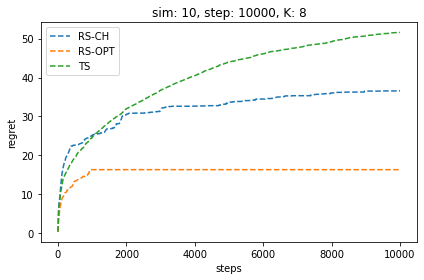

In [273]:
def main():
    trial = 10
    step = 10000
    K = 8
    sim = Simulator(trial, step, K)
    sim.run()


main()